In [8]:
# for loading/processing the images
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from zipfile import ZipFile
from google.colab import drive
from io import BytesIO

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


###Paso 1
Cargo imágenes del zip y las preproceso con el modelo preentrenado quedandome con la capa -2, para obtener las features capturadas pr el modelo.

In [ ]:
ARCHIVO = ('/content/drive/MyDrive/DMCT/Rice_Dataset.zip')

fotos_zip = ZipFile(ARCHIVO)
lista_imágenes = fotos_zip.namelist()
serie_imagenes = pd.Series(lista_imágenes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [ ]:
def get_labels_and_paths(input_folder):
   return sorted([(dp.split("/")[1],os.path.join(dp, f)) for dp, dn, filenames in os.walk(input_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg'])


def extract_features(file, model, zip):

    # levanta imagen como array 224x224
    img = load_img(BytesIO(zip.read(file)) , target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True, verbose=0)
    return features

from tqdm import tqdm
def preprocess(names_and_paths, model, zip):
    preprocessed_data = {}
    for name, path in tqdm(names_and_paths):
    #   print(path)
      featuress = extract_features(path, model, zip)
      preprocessed_data[path] = {'label':name,
                    'features':featuress}
      #print(f"Extracción features de {path}")
    return preprocessed_data


# function that lets you view a cluster (based on identifier)
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [ ]:
ser_arb = serie_imagenes[serie_imagenes.str.startswith('Rice_Image_Dataset/Arborio/A')]
ser_bas = serie_imagenes[serie_imagenes.str.startswith(('Rice_Image_Dataset/Basmati/b','Rice_Image_Dataset/Basmati/B'))]
ser_ips = serie_imagenes[serie_imagenes.str.startswith('Rice_Image_Dataset/Ipsala/I')]
ser_jas = serie_imagenes[serie_imagenes.str.startswith('Rice_Image_Dataset/Jasmine/J')]
ser_kar = serie_imagenes[serie_imagenes.str.startswith('Rice_Image_Dataset/Karacadag/K')]
del lista_imágenes, serie_imagenes

In [ ]:
def label_path(label, paths):
    return [(label, path) for path in paths]

#names_and_paths = get_labels_and_paths(input_folder=ARCHIVO)
names_and_paths = (label_path('Arborio', ser_arb) +
                    label_path('Basmati', ser_bas) +
                    label_path('Ipsala', ser_ips) +
                    label_path('Jasmine', ser_jas) +
                    label_path('Karacadag', ser_kar))


import random
from collections import Counter
from itertools import groupby

# Contar las clases
class_counts = Counter(item[0] for item in names_and_paths)

# Calcular la cantidad mínima de elementos por clase
min_count = 30

# Crear una lista de elementos por clase
grouped_data = {key: [item for item in names_and_paths if item[0] == key] for key in class_counts.keys()}

# Tomar una muestra estratificada
stratified_sample = []
for key, group in grouped_data.items():
    random.shuffle(group)  # Mezcla los elementos para obtener una muestra aleatoria
    stratified_sample.extend(group[:min_count])  # Agrega la misma cantidad de elementos por clase


In [ ]:
# hay que tocar acá para tener una imágen de los arroces antes de procesar las imágenes
# function that lets you view a cluster (based on identifier)
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [ ]:
data_dict = preprocess(names_and_paths=stratified_sample, model=model, zip=fotos_zip)

 16%|█▌        | 8068/50000 [17:10<3:09:35,  3.69it/s]

In [ ]:
labels =  [data_dict[k]['label'] for k in data_dict.keys()]
features = [data_dict[k]['features'][0] for k in data_dict.keys()]
features = np.array(features)

In [ ]:
df_features = pd.DataFrame(features)
df_features.to_csv('/content/drive/MyDrive/DMCT/features.csv', index=False)

In [ ]:
fotos_zip.close()
del fotos_zip

### Paso 2
Acá separo de la parte que usa el modelo vgg16 y levanto las imágenes ya procesadas

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DMCT/Rice_Image_Dataset/features_Arborio.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DMCT/Rice_Image_Dataset/features_Basmati.csv')
df3 = pd.read_csv('/content/drive/MyDrive/DMCT/Rice_Image_Dataset/features_Ipsala.csv')
df4 = pd.read_csv('/content/drive/MyDrive/DMCT/Rice_Image_Dataset/features_Jasmine.csv')
df5 = pd.read_csv('/content/drive/MyDrive/DMCT/Rice_Image_Dataset/features_Karacadag.csv')
features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
del df1,df2,df3,df4,df5

In [6]:
# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)

In [9]:
# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(features, lista_clases, test_size=0.2, random_state=42)

In [10]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(X_train_test)
x = pca.transform(X_train_test)

In [11]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

Text(0, 0.5, 'Var. explicada (%)')

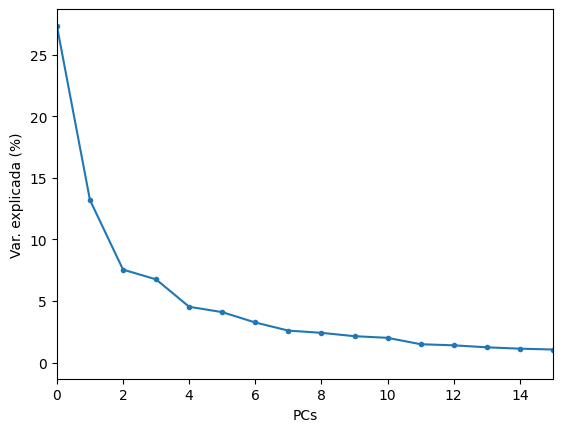

In [29]:
ax = plt.subplot()
ax.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
ax.set_xlim([0,15])
ax.set_xlabel('PCs')
ax.set_ylabel('Var. explicada (%)')

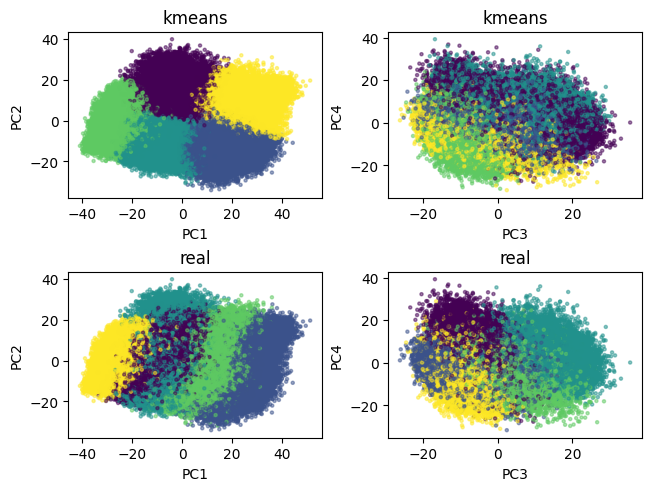

In [19]:
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(x[:,0],x[:,1],s=5,c=kmeans.labels_, alpha=0.5)
axs[0,0].set_xlabel('PC1')
axs[0,0].set_ylabel('PC2')
axs[0,1].scatter(x[:,2],x[:,3],s=5,c=kmeans.labels_, alpha=0.5)
axs[0,1].set_xlabel('PC3')
axs[0,1].set_ylabel('PC4')


axs[1,0].scatter(x[:,0],x[:,1],s=5,c=y_train_test, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=y_train_test, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')


axs[0,0].set_title('kmeans')
axs[0,1].set_title('kmeans')
axs[1,0].set_title('real')
axs[1,1].set_title('real')
fig.set_constrained_layout('constrained')

In [18]:
tmp = pd.DataFrame({'Labels_orig': y_train_test, 'Labels_clust': kmeans.labels_})# Create a DataFrame with labels and varieties as columns: df
ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
ct


Labels_orig,0,1,2,3,4
Labels_clust,,,,,
0,5795,6,5853,463,867
1,145,6170,69,5779,0
2,4825,40,5936,1313,125
3,1182,0,46,1,11079
4,56,5789,13,4448,0
